In [6]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, os.path

SIM_DATAROOT = os.path.join(os.getenv('AIGRAIN_ROTATION', 
                                      os.path.expanduser('~/aigrain_rotation')),
                                      'final')

Let's start exploring using the Aigrain et al. simulated data.  Here's a few example light curves:

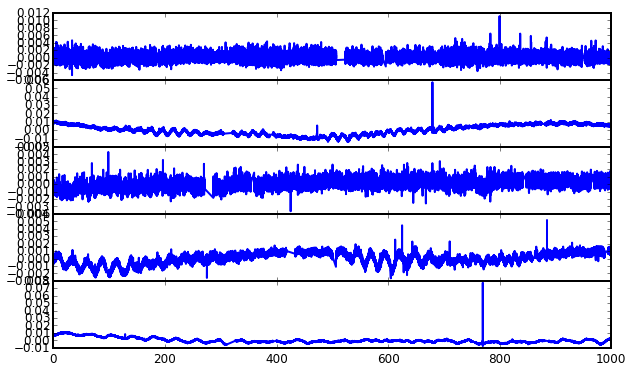

In [222]:
def get_aigrain_data(i, yerr=0.0001, npts=None, binpts=None):
    """
    if binpts is provided, then binpts is the number of points per bin
    
    if npts is provided, then npts random points from the LC will be returned.
    """
    filename = os.path.join(SIM_DATAROOT, 'lightcurve_{:04.0f}.txt'.format(idx))
    x, y = np.loadtxt(filename, unpack=True)
    yerr = np.ones_like(y) * yerr
    
    y -= y.mean() # make zero-mean
    
    if binpts is not None:
        x, y, yerr = bin_data(x, y, yerr, binpts)
    if npts is None:
        return x, y, yerr
    else:
        inds = np.random.randint(len(x), size=npts)
        inds = np.sort(inds)
        return x[inds], y[inds], yerr[inds]

def bin_data(x, y, yerr, npts):
    mod, nbins = len(x) % npts, len(x) / npts
    if mod != 0:
        x, y, yerr = x[:-mod], y[:-mod], yerr[:-mod]
    xb, yb, yerrb = [np.zeros(nbins) for i in range(3)]
    for i in range(npts):
        xb += x[::npts]
        yb += y[::npts]
        yerrb += yerr[::npts]**2
        x, y, yerr = x[1:], y[1:], yerr[1:]
    return xb/npts, yb/npts, yerrb**.5/npts    
    
idxs = [0,100,200,300,400]
fig,axes = plt.subplots(len(idxs), 1, figsize=(10,6), sharex=True, )
for i,idx in enumerate(idxs):
    x, y, yerr = get_aigrain_data(idx)
    axes[i].plot(x,y)
plt.subplots_adjust(hspace=0.0001)

In [214]:
len(x)

44996

OK, so these light curves have ~45000 points.  Let's set up a GP likelihood and see how long an evaluation of this takes on a subset of the data.  Here doing a sum of a matern-3/2 and the rotation kernel.

In [235]:
import george
from george.kernels import ExpSine2Kernel, ExpSquaredKernel, Matern32Kernel

def gpmodel(theta):
    k1 = theta[0] * ExpSquaredKernel(theta[1]) \
            * ExpSine2Kernel(theta[2], theta[4])
    k2 = theta[5] * Matern32Kernel(theta[6])
    return george.GP(k1 + k2)

def lnlike(theta, x, y, yerr):
    """
    The log-likelihood function.
    Uses a squared exponential times an exponential-sine
    kernel function.
    theta is the array of parameters:
    theta = [A2, gamma, l2, sigma, period, A1, l1]
    
    A1 = amplitude of matern-3/2 kernel
    l1 = length scale of the matern kernel
    
    A2 = amplitude of quasiperiodic kernel.
    gamma = scaling factor in the exponential-sine kernel.
    l2 = length scale of the squared-exponential kernel 
    sigma = white noise multiplier
    period = period (obv). In the same units as your 'xs'.

    Params are all logarithms
    """
    theta = np.exp(theta)
    
    gp = gpmodel(theta)
    try:
        gp.compute(x, np.sqrt(theta[3] + yerr**2))
    except (ValueError, np.linalg.LinAlgError):
        return 10e25
    return gp.lnlikelihood(y, quiet=True)

def lnprior(theta, plims):
    if -20 < theta[0] < 20 and -20 < theta[1] < 20 and -20 < theta[2] < 20 \
        and -20 < theta[3] < 20 and plims[0] < theta[4] < plims[1] \
        and -20 < theta[5] < 20 and -20 < theta[6] < 20:
        return 0.
    return -np.inf
    
def lnprob(theta, x, y, yerr, plims):
    return lnlike(theta, x, y, yerr) + lnprior(theta, plims)
     
#x, y, yerr = get_aigrain_data(400, npts=5000)

#theta = [np.log(0.01), np.log(1.), np.log(1.), 
#         np.log(0.0001), np.log(10.), np.log(0.01), np.log(10.)]
#%timeit lnlike(theta, x, y, yerr)
#%timeit lnlike(theta, x[:2000], y[:2000], yerr[:2000])
#%timeit lnlike(theta, x[:1000], y[:1000], yerr[:1000])

OK, this is kinda slow for an MCMC.  On my laptop it's about 3.7s for 5000 points, dropping to about 0.5s for 2000 and 0.1s for 1000 pts.  So can we get away with evaluating only ~1000 points at a time? 

Well, the shortest rotation periods we'd be interested in would be maybe ~1day or so.  Cadence is 0.02 days.  So if we wanted 10 points per day, we could bin 5 points at a time.  This brings us down to ~10,000 points per light curve, and so then what if we draw 1000 of those randomly?  What does that look like?

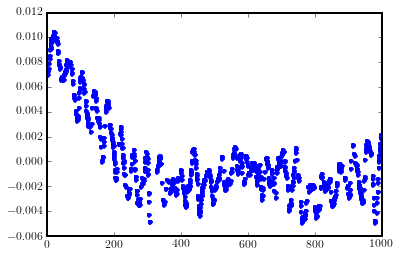

In [239]:
i = 400
x, y, yerr = get_aigrain_data(i, binpts=5, npts=1000)
theta = [np.log(0.01), np.log(1.), np.log(1.), 
         np.log(0.0001), np.log(30.), np.log(0.01), np.log(10.)]
#%timeit lnlike(theta, x, y, yerr)
plt.plot(x, y, '.');

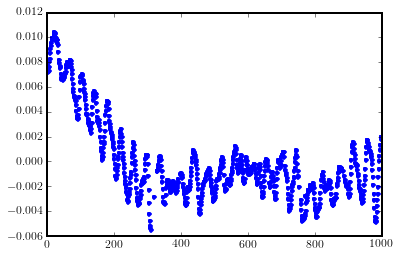

In [244]:
x, y, yerr = get_aigrain_data(i, binpts=50)
plt.plot(x,y, '.')

In [290]:
from george.kernels import ExpSquaredKernel, ExpSine2Kernel

ts = np.linspace(0,10,200)

theta = np.exp([-5., 6., 1.2, np.log(1.16)])
print theta
k =  theta[0]* ExpSquaredKernel(theta[1]) * ExpSine2Kernel(theta[2], theta[3])
gp = george.GP(k)
gp.compute(ts)

[  6.73794700e-03   4.03428793e+02   3.32011692e+00   1.16000000e+00]


LinAlgError: 107-th leading minor not positive definite

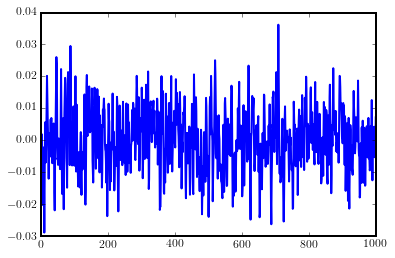

In [282]:
plt.plot(ts, gp.sample(ts));

In [ ]:
import emcee

nwalkers, ndim = 200, 7

theta_init = [np.log(0.01), np.log(1.), np.log(1.), 
             np.log(0.0001), np.log(10.), np.log(0.01), np.log(10.)]

 = 

In [35]:
np.polyfit(t, f, 3)

array([ -4.91772061e-11,   9.75955945e-08,  -6.05868024e-05,
         1.00025183e-02])

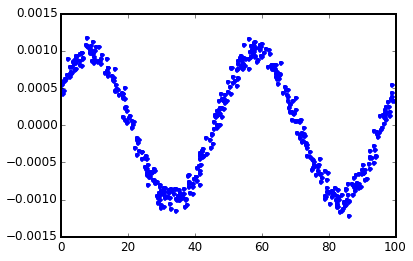

In [161]:
def toy_model(theta, ts):
    A1, P1, w1 = theta    
    return (A1*np.sin(ts * 2*np.pi/P1 + w1))

def toy_data(theta=[0.001, 50, 0.5],
            npts=500, f_err=0.0001):
    t = np.random.random(size=npts)*100
    t = np.sort(t)
    f = toy_model(theta, t) + (np.random.normal(size=npts)*f_err)
    return t, f, f_err*np.ones(npts)

t, f, f_err = toy_data()
plt.plot(t, f, '.')


In [185]:
def toy_lnlike(theta, t, f, f_err):
    if theta[0] < 0 or theta[1] < 0 or theta[1] > 100:
        return -np.inf
    fmod = toy_model(theta, t)
    return (-0.5*(fmod - f)**2 / f_err**2).sum()

def toy_lnlike_bootstrap(theta, t, f, f_err, Npts=50):
    inds = np.random.randint(len(t), size=Npts)
    return toy_lnlike(theta, t[inds], f[inds], f_err[inds])

In [195]:
theta_true = [0.001, 50, 0.5]
t, f, f_err = toy_data(theta_true, f_err = 0.0001)

import emcee

def run_emcee(lnprob=toy_lnlike, nwalkers=200, do_initial=True):

    ndim = 3
    p0 = [[np.random.random()*0.001 + 0.0005,
           np.random.random()*70 + 1,
           np.random.random()*2*np.pi] for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(t,f,f_err))
    pos, prob, state = sampler.run_mcmc(p0, 1000);

    if do_initial:
        #cull out walkers stuck in the mud
        wokinds = np.where((sampler.acceptance_fraction > 0.15) &
                           (sampler.acceptance_fraction < 0.4))[0]
        if len(wokinds)==0:
            print('uh oh. no good walkers? {}'.format(sampler.acceptance_fraction))
            raise RuntimeError
        inds = np.random.randint(len(wokinds), size=nwalkers)
        p0 = sampler.chain[wokinds[inds],:,:].mean(axis=1) #reset p0 using good walkers

        sampler.reset()
        pos, prob, state = sampler.run_mcmc(p0, 1000)
        
    sampler.reset()
    sampler.run_mcmc(pos, 1000);
    return sampler

In [188]:
sampler = run_emcee()

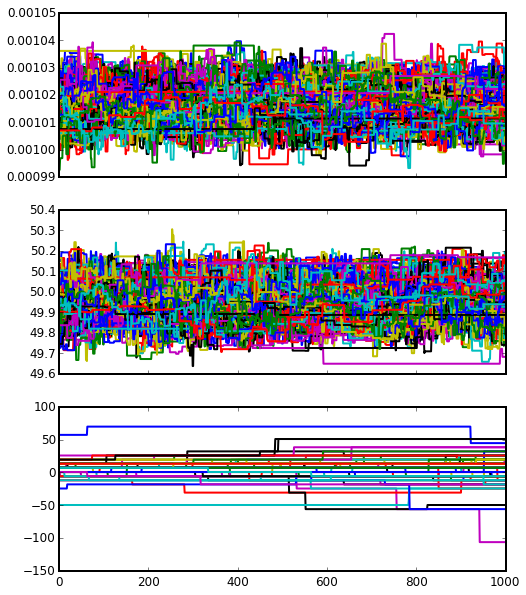

In [190]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8,10))
for i in [0,1,2]:
    axes[i].plot(sampler.chain[:,:,i].T);


In [196]:
sampler_bootstrap = run_emcee(toy_lnlike_bootstrap, do_initial=False)

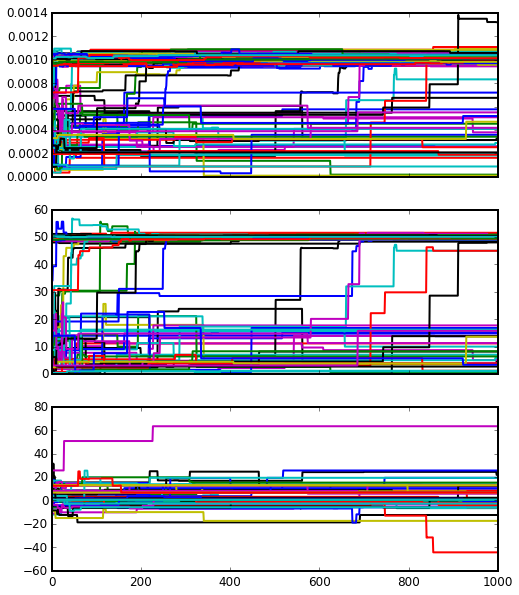

In [197]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8,10))
for i in [0,1,2]:
    axes[i].plot(sampler_bootstrap.chain[:,:,i].T);


OK, this probably won't work.  

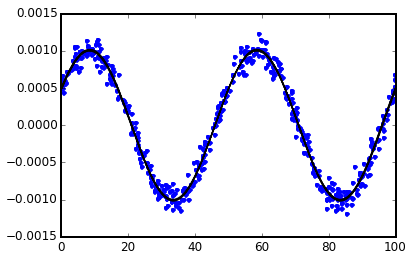

In [181]:
plt.plot(t, f, '.')

for i in np.random.randint(sampler.flatchain.shape[0], size=50):
    plt.plot(t, toy_model(sampler.flatchain[i,:], t), color='k', lw=1, alpha=0.3)


In [169]:
sampler.acceptance_fraction

array([ 0.071,  0.284,  0.31 ,  0.064,  0.097,  0.006,  0.234,  0.288,
        0.305,  0.089,  0.133,  0.004,  0.301,  0.095,  0.111,  0.286,
        0.273,  0.041,  0.298,  0.3  ,  0.01 ,  0.321,  0.043,  0.279,
        0.289,  0.296,  0.297,  0.007,  0.116,  0.   ,  0.001,  0.295,
        0.307,  0.098,  0.186,  0.011,  0.307,  0.301,  0.11 ,  0.288,
        0.108,  0.113,  0.053,  0.047,  0.186,  0.285,  0.004,  0.025,
        0.01 ,  0.011,  0.112,  0.297,  0.015,  0.007,  0.297,  0.107,
        0.023,  0.312,  0.095,  0.102,  0.122,  0.3  ,  0.283,  0.28 ,
        0.009,  0.309,  0.031,  0.072,  0.043,  0.296,  0.13 ,  0.322,
        0.291,  0.083,  0.306,  0.007,  0.286,  0.114,  0.005,  0.289,
        0.075,  0.168,  0.285,  0.314,  0.114,  0.145,  0.09 ,  0.233,
        0.04 ,  0.283,  0.009,  0.15 ,  0.119,  0.021,  0.296,  0.11 ,
        0.202,  0.315,  0.118,  0.297,  0.005,  0.257,  0.086,  0.287,
        0.27 ,  0.31 ,  0.267,  0.315,  0.278,  0.151,  0.01 ,  0.023,
      

In [56]:
toy_cost(theta_init, t, f, f_err)

211265293.82714692

In [ ]:
def toy_lnlike(theta, ts, fs, f_err):

In [18]:
from scipy.optimize import minimize

def lnlike_bootstrap(theta, t, f, f_err, Npts=500):
    inds = np.random.randint(len(t), size=Npts)
    return lnlike(theta, t[inds], f[inds], f_err[inds])

def cost(*args, **kwargs):
    return -lnlike_bootstrap(*args, **kwargs)

theta_init = [np.log(0.01), np.log(1.), np.log(1.), 
         np.log(0.0001), np.log(10.), np.log(0.01), np.log(100.)]

t, f, f_err = get_aigrain_data(400)

minimize(cost, theta_init, args=(t, f, f_err))

/Users/tdm/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:24: RuntimeWarning: overflow encountered in exp


   status: 0
  success: True
     njev: 2
     nfev: 18
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1]])
      fun: -1e+26
        x: array([  7.25542490e+08,  -7.56044874e+08,  -3.38374551e+08,
         5.64666363e+08,  -8.34376306e+08,  -1.31019221e+09,
        -9.72498153e+08])
  message: 'Optimization terminated successfully.'
      jac: array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.])
      nit: 1

(0, 10)

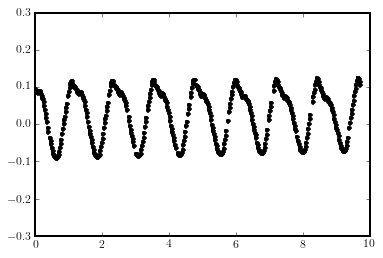

In [291]:
id = "0"
x, y = np.genfromtxt("simulations/%s.txt" % id).T
yerr = np.ones_like(y) * 1e-10  # make up some uncertainties
plt.plot(x, y, "k.")
plt.xlim(0, 10)

In [295]:
p_init = 1.1647
npts = int(p_init / 10. * 48)  # 10 points per period
xb, yb, yerrb = bin_data(x, y, yerr, npts)
cutoff = 100
m = xb < cutoff
xb, yb, yerrb = xb[m], yb[m], yerrb[m]

In [296]:
import GPr
gpr = GPr.GProtation(xb, yb, yerrb)
theta_init = [-5., 6., 1.2, -16., np.log(p_init)]  # initial parameter values

In [302]:
from george.kernels import ExpSquaredKernel, ExpSine2Kernel

theta = np.exp([-5.51441261,   7.37992164,   0.96845914, -10.65503017,   0.20262229])

k = theta[0] * ExpSquaredKernel(theta[1]) \
        * ExpSine2Kernel(theta[2], theta[4])
gp = george.GP(k)
gp.compute(xb, yerrb)

LinAlgError: 124-th leading minor not positive definite